# SIR model: inverse problem
## A PINN approach

In this notebook, we will solve the inverse problem of the SIR model using a Physics-Informed Neural Network (PINN). The goal is to estimate the infection rate $\beta$ from the observed data of the infected population. To do this, we will train a PINN model, where we compute the residuals of the differential equation system with initial conditions and the data loss simultaneously.

The SIR model is governed by the following set of ordinary differential equations (ODEs):

$$
\begin{cases}
\frac{dS}{dt} &= -\frac{\beta}{N} I S, \\
\frac{dI}{dt} &= \frac{\beta}{N} I S - \delta I, \\
\frac{dR}{dt} &= \delta I,
\end{cases}
$$

where $t \in [0, 90]$ and with the initial conditions $S(0) = N - 1$, $I(0) = 1$, and $R(0) = 0$.

## Configuration

In [69]:
from dataclasses import dataclass, field
from IPython.display import display, HTML
from lightning import Callback
from lightning.pytorch import Trainer, LightningModule
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

sns.set_theme(style="darkgrid")

%reload_ext tensorboard
%tensorboard --logdir=logs/tensorboard

Reusing TensorBoard on port 6008 (pid 5559), started 1:33:27 ago. (Use '!kill 5559' to kill it.)

## Module's components

In [70]:
class Square(nn.Module):
    """A module that squares its input element-wise."""
    @staticmethod
    def forward(x):
        return torch.square(x)


def create_mlp(layers_dims, activation, output_activation):
    """Create a multi-layer perceptron with specified architecture."""
    layers = []
    for i in range(len(layers_dims) - 1):
        layers.append(nn.Linear(layers_dims[i], layers_dims[i + 1]))
        if i < len(layers_dims) - 2:
            layers.append(activation)
    layers.append(output_activation)

    net = nn.Sequential(*layers)

    for layer in net:
        if isinstance(layer, nn.Linear):
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

    return net


activation_map = {
    'tanh': nn.Tanh(),
    'relu': nn.ReLU(),
    'leaky_relu': nn.LeakyReLU(),
    'sigmoid': nn.Sigmoid(),
    'selu': nn.SELU(),
    'square': Square(),
    'softplus': nn.Softplus(),
    'identity': nn.Identity()
}

## Module's configuration

In [71]:
@dataclass
class SIRConfig:
    """Configuration for SIR PINN model and training."""
    # Model parameters
    N: float = 56e6
    delta: float = 1 / 5
    r0: float = 3.0
    beta_true: float = delta * r0
    initial_beta: float = 0.5
    
    # Neural network architecture
    hidden_layers: List[int] = field(default_factory=lambda: 4 * [50])
    activation: str = 'tanh'
    output_activation: str = 'softplus'
    
    # Initial conditions (I0, R0)
    initial_conditions: List[float] = field(default_factory=lambda: [1., 0.])
    
    # Training parameters
    learning_rate: float = 1e-3
    batch_size: int = 100
    max_epochs: int = 1000
    
    # Scheduler parameters
    scheduler_factor: float = 0.5
    scheduler_patience: int = 100
    scheduler_threshold: float = 0.01
    scheduler_min_lr: float = 1e-6
    
    # Early stopping
    early_stopping_patience: int = 200
    
    # Loss weights
    pde_weight: float = 1.
    ic_weight: float = 1.
    data_weight: float = 1.
    
    # Dataset parameters
    time_domain: Tuple[int, int] = (0, 90)
    collocation_points: int = 6000
    
    # Logging
    log_every_n_steps: int = 61

## Dataset creation

In [72]:
class SIRDataset(Dataset):
    """Dataset for SIR PINN training."""
    def __init__(
        self, 
        t_obs: np.ndarray, 
        i_obs: np.ndarray, 
        time_domain: Tuple[float, float], 
        n_collocation: int,
        N: float
    ):
        """
        Initialize dataset with observation points and random collocation points.
        The time points are normalized to be in the range [0, 1].
        The infected population is normalized to be in the range [0, 1].
        
        Args:
            t_obs: Observation time points
            i_obs: Observed infected population at each time point
            time_domain: (t_min, t_max) time range
            n_collocation: Number of random collocation points to generate
        """
        t_min, t_max = time_domain
        self.t_obs = torch.tensor(t_obs, dtype=torch.float32).reshape(-1, 1)

        i_norm = i_obs / N
        self.i_obs = torch.tensor(i_norm, dtype=torch.float32).reshape(-1, 1)

        t_rand = np.expm1(np.random.uniform(np.log1p(t_min), np.log1p(t_max), n_collocation))
        self.t_collocation = torch.tensor(t_rand, dtype=torch.float32).reshape(-1, 1)
        
        self.t_combined = torch.cat([self.t_obs, self.t_collocation], dim=0)
        
        self.is_obs = torch.zeros(len(self.t_combined), dtype=torch.bool)
        self.is_obs[:len(self.t_obs)] = True
        
        self.i_targets = torch.zeros(len(self.t_combined), 1, dtype=torch.float32)
        self.i_targets[:len(self.t_obs)] = self.i_obs
        
    def __len__(self):
        return len(self.t_combined)
    
    def __getitem__(self, idx):
        return {
            't': self.t_combined[idx],
            'is_obs': self.is_obs[idx],
            'i_target': self.i_targets[idx]
        }

## Module definition

In [73]:
class SIRPINN(LightningModule):
    """Physics-Informed Neural Network for SIR model parameter identification."""
    
    def __init__(self, config: SIRConfig):
        super().__init__()
        self.save_hyperparameters()
        self.config = config
        
        layers_dims = [1] + config.hidden_layers + [1]
        activation = activation_map.get(config.activation)
        output_activation = activation_map.get(config.output_activation)
        
        self.net_S = create_mlp(layers_dims, activation, output_activation)
        self.net_I = create_mlp(layers_dims, activation, output_activation)
        
        self.beta = nn.Parameter(torch.tensor(config.initial_beta, dtype=torch.float32))
        
        self.N = 1.
        self.delta = config.delta
        
        self.loss_fn = nn.MSELoss()

        self.t0_tensor = torch.zeros(1, 1, device=self.device, dtype=torch.float32)
        i0, r0 = map(lambda x: x / self.config.N, self.config.initial_conditions)
        ic = [self.N - i0 - r0, i0, r0]
        self.ic_true = torch.tensor(ic, dtype=torch.float32).reshape(1, 3)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass to compute S, I, R values at time t.
        
        Args:
            t: Time points tensor of shape [batch_size, 1]
            
        Returns:
            Tensor of shape [batch_size, 3] with [S, I, R] values
        """
        S = self.net_S(t)
        I = self.net_I(t)
        R = self.N - S - I
        
        return torch.cat([S, I, R], dim=1)
        
    @torch.inference_mode(False)
    def compute_ode_residuals(self, t_tensor: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute residuals of the SIR ODEs using automatic differentiation.
        
        Args:
            t: Time points tensor of shape [batch_size, 1]
            
        Returns:
            Tuple of residual tensors (res_S, res_I)
        """
        t_tensor.requires_grad_(True)
        S = self.net_S(t_tensor)
        I = self.net_I(t_tensor)
        
        dS_dt = torch.autograd.grad(
            S, t_tensor, grad_outputs=torch.ones_like(S), create_graph=True
        )[0]
        dI_dt = torch.autograd.grad(
            I, t_tensor, grad_outputs=torch.ones_like(I), create_graph=True
        )[0]

        res_S = dS_dt + self.beta * S * I
        res_I = dI_dt - self.beta * S * I + self.delta * I

        return res_S, res_I
    
    def pde_loss(self, t: torch.Tensor) -> torch.Tensor:
        """Compute PDE residual loss."""
        res_S, res_I = self.compute_ode_residuals(t)
        loss_S = self.loss_fn(res_S, torch.zeros_like(res_S))
        loss_I = self.loss_fn(res_I, torch.zeros_like(res_I))

        return loss_S + loss_I
    
    def ic_loss(self) -> torch.Tensor:
        """Compute initial condition loss."""
        t0_tensor = self.t0_tensor.to(self.device)
        ic_true = self.ic_true.to(self.device)
        ic_pred = self(t0_tensor)

        return self.loss_fn(ic_pred, ic_true)
    
    def data_loss(self, t_obs: torch.Tensor, i_obs: torch.Tensor) -> torch.Tensor:
        """Compute data fitting loss."""
        if t_obs.shape[0] == 0:  # No observations in batch
            return torch.tensor(0.0, device=self.device)     
           
        i_pred = self(t_obs)[:, 1].reshape(-1, 1)
        return self.loss_fn(i_pred, i_obs)
    
    def training_step(self, batch):
        t = batch['t']
        is_obs = batch['is_obs']
        i_target = batch['i_target']
        
        t_obs = t[is_obs] if is_obs.any() else torch.zeros((0, 1), device=self.device)
        i_obs = i_target[is_obs] if is_obs.any() else torch.zeros((0, 1), device=self.device)
        
        pde_loss_val = self.pde_loss(t)
        ic_loss_val = self.ic_loss()
        data_loss_val = self.data_loss(t_obs, i_obs)
        
        total_loss = (
            self.config.pde_weight * pde_loss_val +
            self.config.ic_weight * ic_loss_val +
            self.config.data_weight * data_loss_val
        )
        
        self.log('train/pde_loss', pde_loss_val)
        self.log('train/ic_loss', ic_loss_val)
        self.log('train/data_loss', data_loss_val)
        self.log('train/total_loss', total_loss)
        self.log('train/beta', self.beta.item())
        
        return total_loss
    
    @torch.no_grad()
    def predict_sir(self, t):
        """Predict SIR values at specified time points."""
        t_tensor = torch.tensor(t, dtype=torch.float32).reshape(-1, 1).to(self.device)
        return self(t_tensor).cpu().numpy() * self.config.N
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.config.learning_rate
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=self.config.scheduler_factor,
            patience=self.config.scheduler_patience,
            threshold=self.config.scheduler_threshold,
            min_lr=self.config.scheduler_min_lr
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'train/total_loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }

## Training definition

In [74]:
def train_sir_pinn(t_obs, i_obs, override_config=None):
    """
    Train a SIR PINN model using the provided observations.
    
    Args:
        t_obs: Observation time points
        i_obs: Observed infected proportions
        override_config: Configuration object (optional)
        
    Returns:
        Trained PINN model
    """
    if override_config is None:
        config = SIRConfig()
    else:
        config = override_config
    
    dataset = SIRDataset(
        t_obs=t_obs,
        i_obs=i_obs,
        time_domain=config.time_domain,
        n_collocation=config.collocation_points,
        N=config.N
    )

    data_loader = DataLoader(
        dataset,
        batch_size=config.batch_size,
        shuffle=True,
    )
    
    model = SIRPINN(config)

    callbacks: list[Callback] = [
        # EarlyStopping(
        #     monitor='val/total_loss',
        #     patience=config.early_stopping_patience,
        #     mode='min'
        # ),
        LearningRateMonitor(logging_interval='epoch')
    ]

    loggers = [
        TensorBoardLogger(save_dir="logs/tensorboard", name=""),
        CSVLogger(save_dir="logs/csv", name="")
    ]

    trainer = Trainer(
        max_epochs=config.max_epochs,
        callbacks=callbacks,
        log_every_n_steps=config.log_every_n_steps,
        logger=loggers
    )
    
    trainer.fit(model, data_loader)
    
    return model

## Execution 

Generate syntethic data:

In [75]:
config = SIRConfig()

def sir(x, _, d, b):
  s, i, _ = x
  l = b * i / config.N
  ds_dt = -l * s
  di_dt = l * s - d * i
  dr_dt = d * i
  return np.array([ds_dt, di_dt, dr_dt])

i0, r0 = config.initial_conditions
t_start, t_end = config.time_domain

t = np.linspace(t_start, t_end, t_end - t_start + 1)

solution = odeint(sir, [config.N - i0 - r0, i0, r0], t, args=(config.delta, config.beta_true))
s_true = solution[:, 0]
i_true = solution[:, 1]
r_true = solution[:, 2]

i_obs = np.random.poisson(i_true)

Execute the training with the generated data:

In [76]:
model = train_sir_pinn(t, i_obs)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | net_S        | Sequential | 7.8 K  | train
1 | net_I        | Sequential | 7.8 K  | train
2 | loss_fn      | MSELoss    | 0      | train
  | other params | n/a        | 1      | n/a  
----------------------------------------------------
15.6 K    Trainable params
0         Non-trainable params
15.6 K    Total params
0.062     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


## Evaluation

In [77]:
s_pred, i_pred, r_pred = model.predict_sir(t).T
beta_pred = model.beta.item()

Model predition

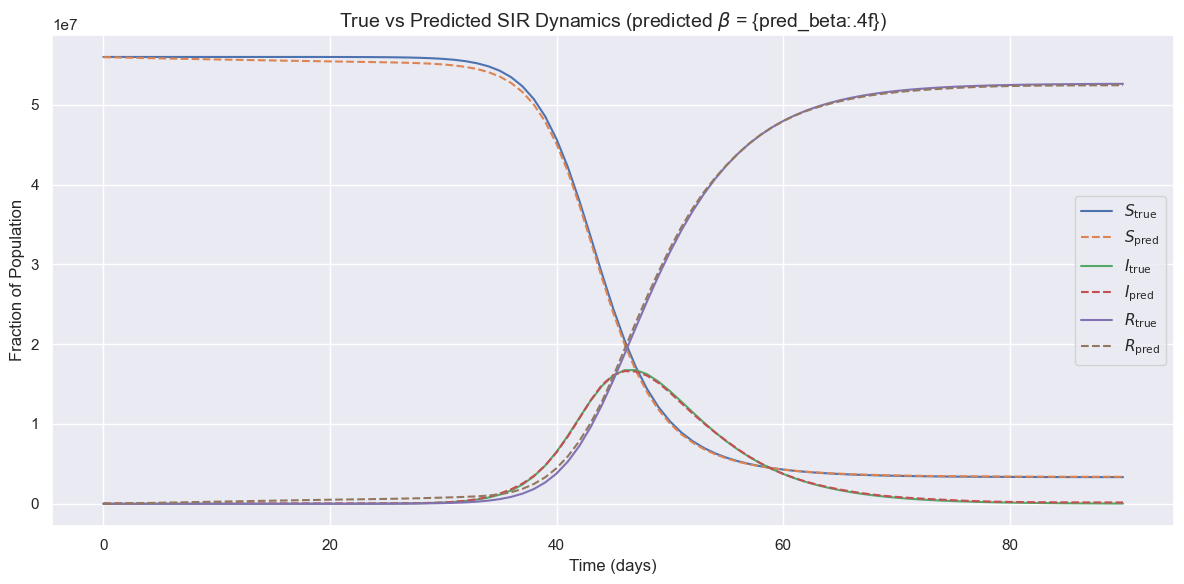

In [78]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=t, y=s_true, label="$S_{\\mathrm{true}}$")
sns.lineplot(x=t, y=s_pred, label="$S_{\\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t, y=i_true, label="$I_{\\mathrm{true}}$")
sns.lineplot(x=t, y=i_pred, label="$I_{\\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t, y=r_true, label="$R_{\\mathrm{true}}$")
sns.lineplot(x=t, y=r_pred, label="$R_{\\mathrm{pred}}$", linestyle="--")

plt.title('True vs Predicted SIR Dynamics (predicted $\\beta$ = {pred_beta:.4f})', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Fraction of Population', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Preditions accuracy

In [79]:
def mse(pred, true):
  """Calculate Mean Squared Error between predicted and true values."""
  return np.mean((pred - true) ** 2)


def re(pred, true):
  """Calculate Relative Error between predicted and true values."""
  return np.linalg.norm(true - pred, 2) / np.linalg.norm(true, 2)


def mape(pred, true):
  """Calculate Mean Absolute Percentage Error between predicted and true values."""
  return mean_absolute_percentage_error(true, pred)


compartments = ["S", "I", "R"]
pred_arrays = [s_pred, i_pred, r_pred]
true_arrays = [s_true, i_true, r_true]

mse_values = [
  f"{mse(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]
re_values = [
  f"{re(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]
mape_values = [
  f"{mape(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]

errors = pd.DataFrame(
  {
    "Compartment": compartments,
    "MSE":         mse_values,
    "MAPE (%)":    mape_values,
    "RE":          re_values,
  }
)

display(HTML(errors.to_html(index=False)))

Compartment,MSE,MAPE (%),RE
S,1.55e+11,1.20e-02,1.03e-02
I,7.55e+09,1.61e+03,1.54e-02
R,1.53e+11,7.69e+17,1.17e-02


In [80]:
beta_error = abs(beta_pred - config.beta_true)
beta_error_percent = beta_error / config.beta_true * 100

beta_errors = pd.DataFrame(
  {
    "Parameter":          ["β"],
    "Predicted Value":    [f"{beta_pred:.4f}"],
    "True Value":         [f"{config.beta_true:.4f}"],
    "Absolute Error":     [f"{beta_error:.2e}"],
    "Relative Error (%)": [f"{beta_error_percent:.2f}%"],
  }
)

display(HTML(beta_errors.to_html(index=False)))

Parameter,Predicted Value,True Value,Absolute Error,Relative Error (%)
β,0.6031,0.6000,3.09e-03,0.51%
